In [ ]:
# Install kaggle
!pip install -q kaggle

In [ ]:
# Upload kaggle.json file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"caramelsashimi","key":"2d476f80c96b953fc1707d288d9e1c90"}'}

In [ ]:
# Create a .kaggle directory and move the kaggle.json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Download the dataset
!kaggle datasets download -d thedevastator/tweet-sentiment-s-impact-on-stock-returns

Dataset URL: https://www.kaggle.com/datasets/thedevastator/tweet-sentiment-s-impact-on-stock-returns
License(s): CC0-1.0
  0% 0.00/57.9M [00:00<?, ?B/s]
100% 57.9M/57.9M [00:00<00:00, 826MB/s]


In [ ]:
!unzip tweet-sentiment-s-impact-on-stock-returns.zip

Archive:  tweet-sentiment-s-impact-on-stock-returns.zip
  inflating: full_dataset-release.csv  
  inflating: reduced_dataset-release.csv  


In [ ]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv("/content/full_dataset-release.csv")
df2 = pd.read_csv("/content/reduced_dataset-release.csv")

<ipython-input-8-ee9efdbeacba>:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/full_dataset-release.csv")
<ipython-input-8-ee9efdbeacba>:2: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv("/content/reduced_dataset-release.csv")


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1395450 entries, 0 to 1395449
Data columns (total 14 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   Unnamed: 0         1102013 non-null  object 
 1   TWEET              1395398 non-null  object 
 2   STOCK              862231 non-null   object 
 3   DATE               862231 non-null   object 
 4   LAST_PRICE         862231 non-null   float64
 5   1_DAY_RETURN       862231 non-null   float64
 6   2_DAY_RETURN       862231 non-null   float64
 7   3_DAY_RETURN       862231 non-null   float64
 8   7_DAY_RETURN       862231 non-null   float64
 9   PX_VOLUME          862231 non-null   float64
 10  VOLATILITY_10D     862130 non-null   float64
 11  VOLATILITY_30D     862184 non-null   float64
 12  LSTM_POLARITY      661102 non-null   float64
 13  TEXTBLOB_POLARITY  367665 non-null   float64
dtypes: float64(10), object(4)
memory usage: 149.1+ MB


# EDA

In [ ]:
df_temp = df.copy()
df_temp = df_temp.dropna()
df_temp = df_temp.drop_duplicates()

count = df_temp['STOCK'].value_counts()
perc = count/count.sum()
dstr = pd.DataFrame({"Count": count, "Percentage": perc}).reset_index()
dstr

,STOCK,Count,Percentage
0,Ford,52198,0.141989
1,Facebook,40837,0.111085
2,Google,33697,0.091663
3,Next,32606,0.088695
4,Apple,27940,0.076002
...,...,...,...
96,Volkswagen,18,0.000049
97,Equinor,12,0.000033
98,CVS Health,11,0.000030
99,21CF,4,0.000011


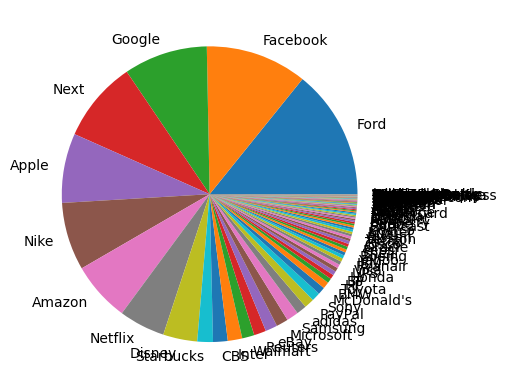

In [ ]:
plt.pie(dstr['Count'], labels = dstr['STOCK'])
plt.show()

In [ ]:
# Top 5 stocks (~50% share of tweets)
TOP_STOCKS = dstr['STOCK'].head().to_list()

# Middle 25%
MID_STOCKS = dstr['STOCK'].iloc[5:].head().to_list()

# Bottom 25% (Below Starbucks)
BOT_STOCKS = dstr['STOCK'].iloc[10:].to_list()

# Cleaning

In [ ]:
# COL = ['Ford', 'Facebook', 'Google']
df_top = df[df['STOCK'].isin(TOP_STOCKS) | df['TWEET'].isin(TOP_STOCKS)]
df_top = df_top.reset_index(drop=True)
l1 = len(df_top)
l2 = len(df_top[df_top['Unnamed: 0'].isnull()])
df_top[df_top['Unnamed: 0'].isnull()]
print(f"Expected cleaned df size: {l1 - l2}")

df_mid = df[df['STOCK'].isin(MID_STOCKS) | df['TWEET'].isin(MID_STOCKS)]
df_mid = df_mid.reset_index(drop=True)
l1 = len(df_mid)
l2 = len(df_mid[df_mid['Unnamed: 0'].isnull()])
df_mid[df_mid['Unnamed: 0'].isnull()]
print(f"Expected cleaned df size: {l1 - l2}")

df_bot = df[df['STOCK'].isin(BOT_STOCKS) | df['TWEET'].isin(BOT_STOCKS)]
df_bot = df_bot.reset_index(drop=True)
l1 = len(df_bot)
l2 = len(df_bot[df_bot['Unnamed: 0'].isnull()])
df_bot[df_bot['Unnamed: 0'].isnull()]
print(f"Expected cleaned df size: {l1 - l2}")

Expected cleaned df size: 187342
Expected cleaned df size: 89848
Expected cleaned df size: 90622


In [ ]:
# Function to fix misalignment
def fix_misalignment(df):

    # Copy the original DataFrame to avoid altering it directly
    df = df.copy()

    # Create a mask where the first column is NaN
    mask = df.iloc[:, 0].isna()

    # Iterate over rows where the mask is True
    for idx in df[mask].index.tolist():  # Use a list of indices to avoid dynamic changes
        # Get the previous row index
        previous_idx = idx - 1

        # Ensure the previous index is valid and within bounds
        if previous_idx in df.index:
            for col in range(1, len(df.columns)):
                # Check if the current value is non-NaN
                if not pd.isna(df.iloc[idx, col]):
                    # Ensure the column is within bounds of the previous row
                    if col+1 < len(df.columns):
                        df.iloc[previous_idx, col+1] = df.iloc[idx, col]

    # Drop rows where the first column is NaN
    df = df[~mask]

    return df

In [ ]:
# 22 MINUTE RUNTIME

# BOT
start_time = time.time()

df_bot_cleaned = fix_misalignment(df_bot)

end_time = time.time()
runtime = end_time - start_time
print(f'RUNTIME: {runtime:.2f} seconds')

# MID
start_time = time.time()

df_mid_cleaned = fix_misalignment(df_mid)

end_time = time.time()
runtime = end_time - start_time
print(f'RUNTIME: {runtime:.2f} seconds')

# TOP
start_time = time.time()

df_top_cleaned = fix_misalignment(df_top)

end_time = time.time()
runtime = end_time - start_time
print(f'RUNTIME: {runtime:.2f} seconds')

<ipython-input-14-eb71524ede21>:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '31.83' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.iloc[previous_idx, col+1] = df.iloc[idx, col]


RUNTIME: 679.72 seconds


<ipython-input-14-eb71524ede21>:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '823.48' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.iloc[previous_idx, col+1] = df.iloc[idx, col]


RUNTIME: 722.44 seconds


<ipython-input-14-eb71524ede21>:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '130.32' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.iloc[previous_idx, col+1] = df.iloc[idx, col]


RUNTIME: 2264.15 seconds


In [ ]:
df_top_cleaned = df_top_cleaned.reset_index(drop=True)
df_top_cleaned = df_top_cleaned.drop('Unnamed: 0', axis=1)
df_top_cleaned

,TWEET,STOCK,DATE,LAST_PRICE,1_DAY_RETURN,2_DAY_RETURN,3_DAY_RETURN,7_DAY_RETURN,PX_VOLUME,VOLATILITY_10D,VOLATILITY_30D,LSTM_POLARITY,TEXTBLOB_POLARITY
0,RT @IndiaHistorypic: 1994::Young @sundarpichai...,Google,31/01/2017,820.19,0.004438,0.030286,0.030286,0.035772,2020180.0,21.549,14.953,-1.0,0.0000
1,"RT @Google: ""If you have the feeling that some...",Google,31/01/2017,820.19,0.004438,0.030286,0.030286,0.035772,2020180.0,21.549,14.953,-1.0,-0.5500
2,"RT @IBMWatson: Welcome @Apple, #ACLU, #AAAI, @...",Apple,31/01/2017,121.35,0.002307,0.004944,0.004944,-0.011372,49200993.0,9.114,8.417,1.0,1.0000
3,RT @ColMorrisDavis: My family owned a @Ford de...,Ford,31/01/2017,12.36,0.000809,0.010518,0.010518,0.020227,46974479.0,26.321,27.647,1.0,0.0000
4,RT @ThatBitchFromNJ: Google's sponsored ad for...,Google,31/01/2017,820.19,0.004438,0.030286,0.030286,0.035772,2020180.0,21.549,14.953,-1.0,-0.1000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
187337,RT @time2trade2: @McAllisterDen Trump called f...,Ford,30/09/2018,9.25,0.000000,0.000000,-0.002162,0.064865,30987233.0,23.492,22.989,1.0,0.0000
187338,Thanks Google\r\r\r\r\r\r\n\r\r\r\r\r\r\nHey L...,Ford,30/09/2018,9.25,0.000000,0.000000,-0.002162,0.064865,30987233.0,23.492,22.989,1.0,0.0000
187339,RT @rmbyrne: Do you have any colleagues who th...,Google,30/09/2018,1207.08,0.000000,0.000000,0.000232,-0.028962,1780759.0,15.005,17.588,-1.0,-0.0625
187340,RT @AnnCoulter: Item No. 3 for FBI to investig...,Ford,30/09/2018,9.25,0.000000,0.000000,-0.002162,0.064865,30987233.0,23.492,22.989,-1.0,0.0000


In [ ]:
df_mid_cleaned = df_mid_cleaned.reset_index(drop=True)
df_mid_cleaned = df_mid_cleaned.drop('Unnamed: 0', axis=1)
df_mid_cleaned

,TWEET,STOCK,DATE,LAST_PRICE,1_DAY_RETURN,2_DAY_RETURN,3_DAY_RETURN,7_DAY_RETURN,PX_VOLUME,VOLATILITY_10D,VOLATILITY_30D,LSTM_POLARITY,TEXTBLOB_POLARITY
0,"RT @nikitakhara: Thank you, @Starbucks CEO for...",Amazon,31/01/2017,823.48,0.008379,0.014924,0.014924,-0.001263,3137196.0,13.447,16.992,-1.0,0.800000
1,RT @cultcommoncore: Dumping @Starbucks\r\r\r\r...,Starbucks,31/01/2017,55.22,0.012314,0.016298,0.016298,0.058312,14307985.0,23.916,17.298,-1.0,0.000000
2,@amazon has your back when it comes to food sh...,Netflix,31/01/2017,140.71,0.003624,0.012366,0.012366,-0.004264,4411631.0,27.398,24.135,1.0,1.000000
3,"RT @nia4_trump: So instead of hiring 10,000 un...",Amazon,31/01/2017,823.48,0.008379,0.014924,0.014924,-0.001263,3137196.0,13.447,16.992,1.0,0.000000
4,Hmmm interesting... \r\r\r\r\r\r\nonly @IBM ha...,Amazon,31/01/2017,823.48,0.008379,0.014924,0.014924,-0.001263,3137196.0,13.447,16.992,-1.0,0.800000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
89843,"I'm at Starbucks in Al-Andalus, Al Asimah http...",Starbucks,30/09/2018,56.84,0.000000,0.000000,0.008797,0.010732,8975955.0,17.035,13.123,-1.0,0.000000
89844,RT @suzford: This bodes well! #JulieRapaport n...,Amazon,30/09/2018,2003.0,0.000000,0.000000,0.004983,-0.043929,4085135.0,20.709,22.946,1.0,0.000000
89845,RT @shopWSS: Celebrating 90 years of Mickey Mo...,Nike,30/09/2018,84.72,0.000000,0.000000,-0.002125,0.009797,7452735.0,20.470,20.016,1.0,0.458333
89846,RT @radiodisney: Tune in to the Radio Disney I...,Disney,30/09/2018,116.94,0.000000,0.000000,-0.007696,-0.055926,7366846.0,15.232,13.230,1.0,0.000000


In [ ]:
df_bot_cleaned = df_bot_cleaned.reset_index(drop=True)
df_bot_cleaned = df_bot_cleaned.drop('Unnamed: 0', axis=1)
df_bot_cleaned

,TWEET,STOCK,DATE,LAST_PRICE,1_DAY_RETURN,2_DAY_RETURN,3_DAY_RETURN,7_DAY_RETURN,PX_VOLUME,VOLATILITY_10D,VOLATILITY_30D,LSTM_POLARITY,TEXTBLOB_POLARITY
0,@FAME95FM1 Jamaicans make money with @Payoneer...,PayPal,31/01/2017,39.78,0.002011,0.012318,0.012318,0.054801,9100057.0,18.769,16.099,-1.0,0.000000
1,@CBSi Jamaicans make money with @Payoneer @Pay...,PayPal,31/01/2017,39.78,0.002011,0.012318,0.012318,0.054801,9100057.0,18.769,16.099,1.0,0.000000
2,@Hitz92fm Jamaicans make money with @Payoneer ...,eBay,31/01/2017,31.83,0.010682,0.021363,0.021363,-0.057807,9469076.0,33.029,22.932,1.0,-0.166667
3,@gawker Jamaicans make money with @Payoneer @P...,CBS,31/01/2017,64.49,-0.001396,0.003877,0.003877,-0.023414,3523867.0,16.338,16.302,1.0,0.000000
4,@Dal_Schnur @DKuzLA @wrightco0704 @psuba98 @Re...,HSBC,31/01/2017,676.4,0.005322,0.016558,0.016558,-0.005322,27693980.0,12.549,15.009,1.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
90617,RT @SyriaArchivist: @ReutersWorld How about Re...,Walmart,30/09/2018,93.91,0.000000,0.000000,0.002343,0.021191,6306274.0,8.702,11.667,-1.0,0.250000
90618,24 Destinations Where You Can Stay\r\r\r\r\r\r...,eBay,30/09/2018,33.02,0.000000,0.000000,0.009691,0.030890,8467405.0,22.738,17.202,1.0,0.000000
90619,"RT @DrKanyuira: In Japan, youths in their mid...",Honda,30/09/2018,3439.0,0.000000,0.000000,-0.009305,0.015121,5554600.0,26.410,22.868,-1.0,-0.063889
90620,RT @Spicywienerprod: The #sexy Roxy Cox Follo...,Reuters,30/09/2018,50.3139,0.000000,0.000000,0.000876,-0.006785,7988967.0,6.838,12.771,1.0,0.000000


In [ ]:
df_top_cleaned.to_csv('/content/df_top_cleaned.csv', index=False)
df_mid_cleaned.to_csv('/content/df_mid_cleaned.csv', index=False)
df_bot_cleaned.to_csv('/content/df_bot_cleaned.csv', index=False)

# Modeling

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import time
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
df_top_cleaned = pd.read_csv("/content/df_top_cleaned.csv")
df_mid_cleaned = pd.read_csv("/content/df_mid_cleaned.csv")
df_bot_cleaned = pd.read_csv("/content/df_bot_cleaned.csv")

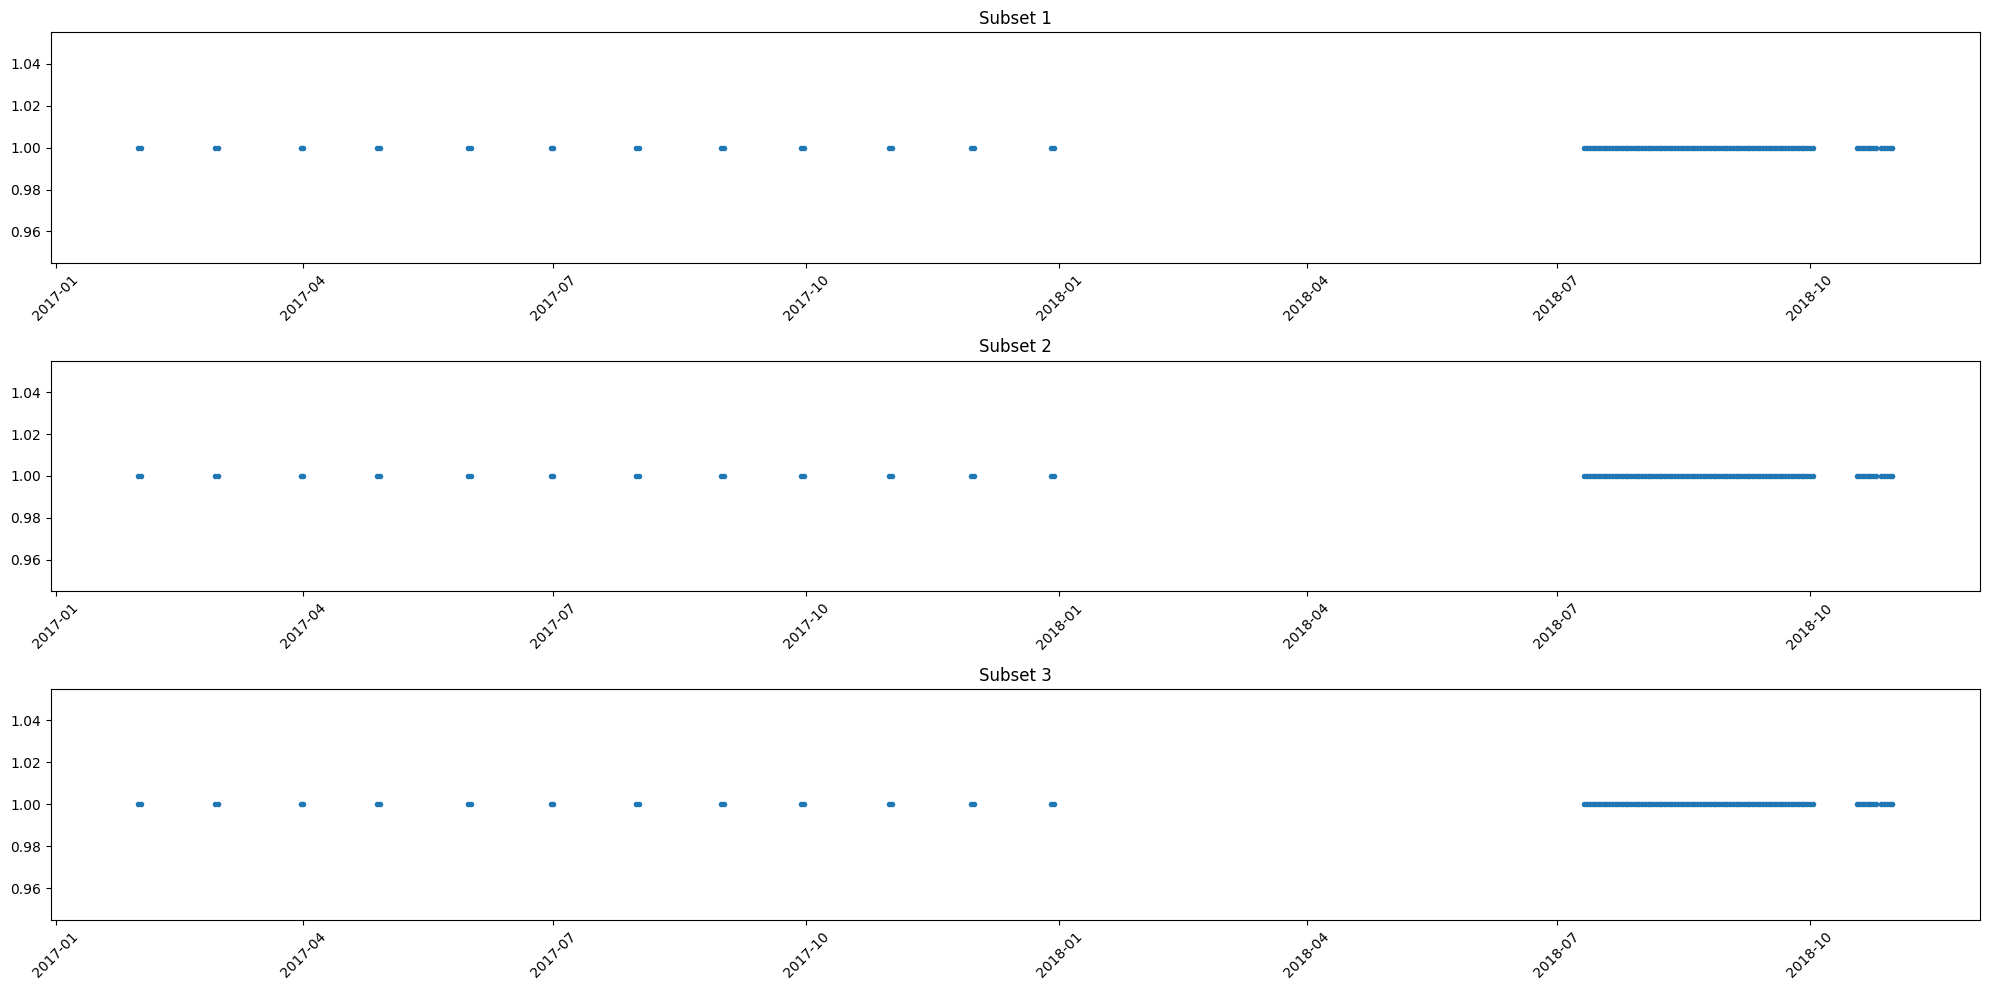

In [ ]:
df_top_cleaned['DATE'] = pd.to_datetime(df_top_cleaned['DATE'])
df_mid_cleaned['DATE'] = pd.to_datetime(df_mid_cleaned['DATE'])
df_bot_cleaned['DATE'] = pd.to_datetime(df_bot_cleaned['DATE'])

# Dates seems to be non-concsecutive until 2018-7-11
fig, ax, = plt.subplots(3, 1, figsize=(20, 10))
id=0
for df in [df_top_cleaned, df_mid_cleaned, df_bot_cleaned]:
    dates = df['DATE'].sort_values().unique()
    ax[id].scatter(x=dates, y=[1]*len(dates), marker='.')
    ax[id].tick_params(axis='x', rotation=45)
    ax[id].set_title(f"Subset {id + 1}")
    id += 1
plt.tight_layout()
plt.show()

In [ ]:
# zooming in at the data break in oct 2018
df_top_cleaned['DATE'].sort_values().unique()[100:120]

<DatetimeArray>
['2018-09-25 00:00:00', '2018-09-26 00:00:00', '2018-09-27 00:00:00',
 '2018-09-28 00:00:00', '2018-09-29 00:00:00', '2018-09-30 00:00:00',
 '2018-10-01 00:00:00', '2018-10-02 00:00:00', '2018-10-18 00:00:00',
 '2018-10-19 00:00:00', '2018-10-20 00:00:00', '2018-10-21 00:00:00',
 '2018-10-22 00:00:00', '2018-10-23 00:00:00', '2018-10-24 00:00:00',
 '2018-10-25 00:00:00', '2018-10-27 00:00:00', '2018-10-28 00:00:00',
 '2018-10-29 00:00:00', '2018-10-30 00:00:00']
Length: 20, dtype: datetime64[ns]

In [ ]:
# Function to slice dataframe to keep only dates after 2018-7-11
def slice_date(df):
    df = df[(df['DATE'] >= '2018-7-11') & (df['DATE'] <= '2018-10-2')].sort_values(by='DATE')
    df = df.reset_index(drop=True)
    return df

df_top_cleaned = slice_date(df_top_cleaned)
df_mid_cleaned = slice_date(df_mid_cleaned)
df_bot_cleaned = slice_date(df_bot_cleaned)

In [ ]:
print(df_top_cleaned.isnull().sum())
print(df_mid_cleaned.isnull().sum())
print(df_bot_cleaned.isnull().sum())
df_bot_cleaned = df_bot_cleaned.dropna() # ok since we're only dropping 1 row

TWEET                0
STOCK                0
DATE                 0
LAST_PRICE           0
1_DAY_RETURN         0
2_DAY_RETURN         0
3_DAY_RETURN         0
7_DAY_RETURN         0
PX_VOLUME            0
VOLATILITY_10D       0
VOLATILITY_30D       0
LSTM_POLARITY        0
TEXTBLOB_POLARITY    0
dtype: int64
TWEET                0
STOCK                0
DATE                 0
LAST_PRICE           0
1_DAY_RETURN         0
2_DAY_RETURN         0
3_DAY_RETURN         0
7_DAY_RETURN         0
PX_VOLUME            0
VOLATILITY_10D       0
VOLATILITY_30D       0
LSTM_POLARITY        0
TEXTBLOB_POLARITY    0
dtype: int64
TWEET                0
STOCK                0
DATE                 0
LAST_PRICE           0
1_DAY_RETURN         0
2_DAY_RETURN         0
3_DAY_RETURN         0
7_DAY_RETURN         0
PX_VOLUME            0
VOLATILITY_10D       0
VOLATILITY_30D       0
LSTM_POLARITY        0
TEXTBLOB_POLARITY    1
dtype: int64


In [ ]:
print(df_top_cleaned['STOCK'].unique())
print(df_mid_cleaned['STOCK'].unique())
print(df_bot_cleaned['STOCK'].unique())

['Google' 'Facebook' 'Ford' 'Apple' 'Next']
['Amazon' 'Netflix' 'Nike' 'Disney' 'Starbucks']
['Visa' 'BMW' 'Comcast' 'PayPal' 'adidas' 'Microsoft' 'HP' 'Yahoo'
 'Samsung' 'Pfizer' 'Kroger' 'Ryanair' 'Verizon' 'eBay' "McDonald's"
 'Toyota' 'Walmart' 'BP' 'Sony' 'Intel' 'Cisco' 'CBS' 'Honda' 'Costco'
 'FedEx' 'Reuters' 'Burberry' 'Mastercard' 'IBM' 'Exxon' 'Gillette' 'Audi'
 'Heineken' 'Nestle' 'UPS' 'Siemens' 'BASF' 'Chevron' 'SAP' 'ASOS' 'Pepsi'
 'Nissan' 'Groupon' 'Shell' 'Hyundai' 'Colgate' 'Tesco' 'Adobe' 'Allianz'
 'Citigroup' 'Oracle' 'Bayer' "Kellogg's" 'Carrefour' 'Santander'
 'TripAdvisor' 'JPMorgan' 'CocaCola' 'Vodafone' 'HSBC' 'AstraZeneca'
 'Boeing' 'GSK' 'BlackRock' 'Thales' 'Aviva' 'Expedia' 'TMobile' 'easyJet'
 'Danone' 'Viacom' "L'Oreal" 'Equinor' '21CF' 'AT&T' 'Bank of America'
 'American Express' 'Home Depot' 'bookingcom' 'Morgan Stanley'
 'salesforce.com' 'Volkswagen' 'Goldman Sachs' 'Deutsche Bank'
 'Wells Fargo' 'H&M' 'General Electric' 'P&G' 'John Deere'
 'Cardinal

In [ ]:
def compute_multiple_returns(df):
    df = df.sort_values(['STOCK', 'DATE']).reset_index(drop=True)
    df['DATE'] = pd.to_datetime(df['DATE'])

    for days in [1, 2, 3, 7]:
        df[f'{days}_DAY_RETURN'] = (
            df.groupby('STOCK')['PX_VOLUME']
            .transform(lambda x: x.shift(-days) / x - 1)
        )
    return df

In [ ]:
df_all_cleaned = pd.concat([df_top_cleaned, df_mid_cleaned, df_bot_cleaned], ignore_index=True)

In [ ]:
df_all_cleaned = compute_multiple_returns(df_all_cleaned)

In [ ]:
def group_df(df):
    agg_dict = {
        'LSTM_POLARITY': 'mean',           # Average sentiment if multiple tweets
        'TEXTBLOB_POLARITY': 'mean',
        'LAST_PRICE': 'mean',             # Assuming price doesn’t change intraday
        'PX_VOLUME': 'mean',               # Average if tweets differ slightly
        'VOLATILITY_10D': 'mean',
        'VOLATILITY_30D': 'mean',
        '1_DAY_RETURN': 'mean',
        '2_DAY_RETURN': 'mean',
        '3_DAY_RETURN': 'mean',
        '7_DAY_RETURN': 'mean',
        'TWEET': lambda x: ' '.join(x)     # Optional: Concatenate all tweets for NLP
    }

    return df.groupby(['STOCK', 'DATE'], as_index=False).agg(agg_dict).reset_index(drop=True)


In [ ]:
df_all = group_df(df_all_cleaned)

In [ ]:
df_all.dropna(subset=['1_DAY_RETURN', '2_DAY_RETURN', '3_DAY_RETURN', '7_DAY_RETURN'], inplace=True)

In [ ]:
# Create direction features for each horizon
def create_direction_features(df):
    for days in [1, 2, 3, 7]:
        col = f'{days}_DAY_RETURN'
        df[f'DIRECTION_{days}D'] = df[col].apply(lambda x: 0 if pd.isna(x) or x < 0 else 1)
    return df

df_all = create_direction_features(df_all)

In [ ]:
# Print class balance for each return horizon on the concatenated dataframe
print("Overall Direction Weights:")
for days in [1, 2, 3, 7]:
    col = f'DIRECTION_{days}D'
    if col in df_all.columns:
        weight = df_all[col].mean()
        print(f"  {days}-Day Positive Class Proportion: {weight:.2%}")
    else:
        print(f"  {days}-Day: Column {col} not found in df_all.")

Overall Direction Weights:
  1-Day Positive Class Proportion: 63.24%
  2-Day Positive Class Proportion: 61.77%
  3-Day Positive Class Proportion: 60.67%
  7-Day Positive Class Proportion: 58.32%


In [ ]:
# Copy df for original features and enginereed features
df_ori = df_all.copy()
df_eng = df_all.copy()

# EDA

NameError: name 'df_top_final' is not defined

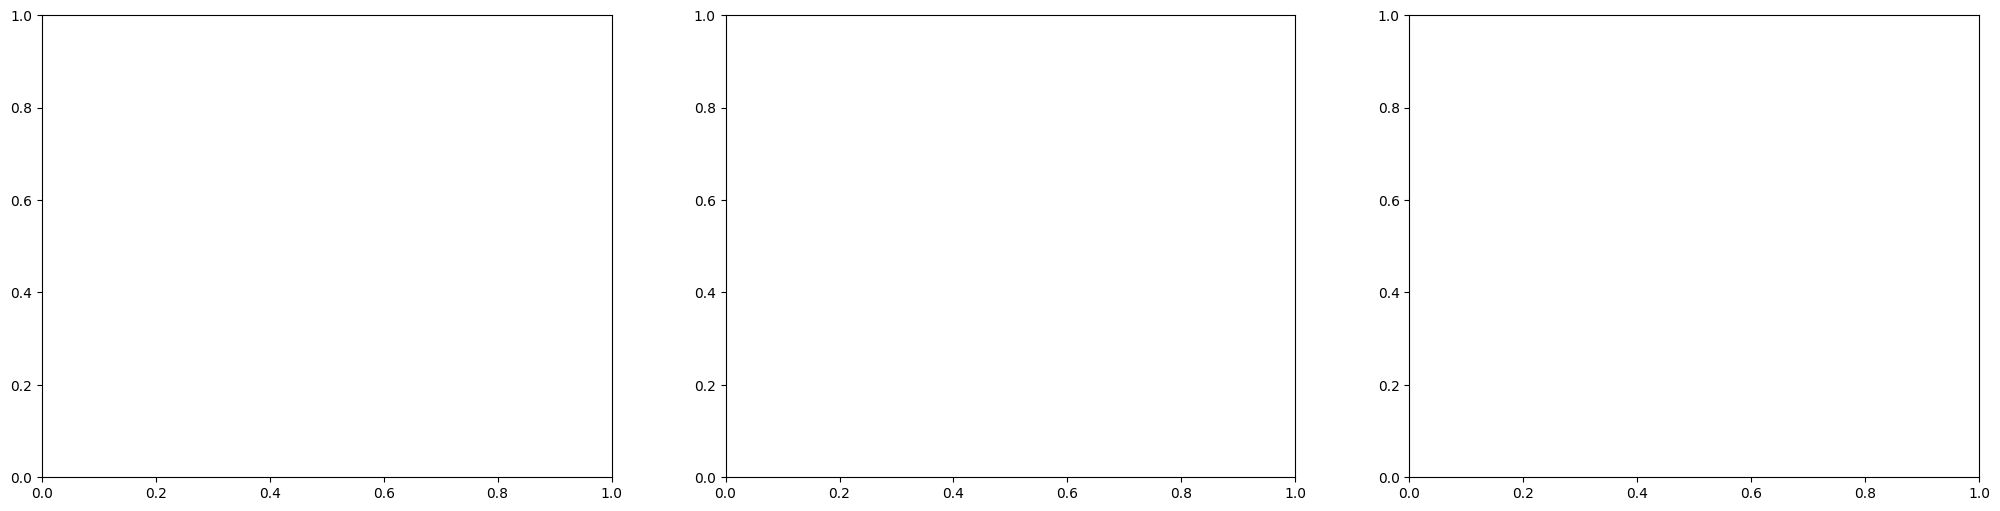

In [ ]:
# Create Heatmaps
fig, axes = plt.subplots(1, 3, figsize=(25, 6))
idx = 0

for df in [df_top_final, df_mid_final, df_bot_final]:

    # Feature correlation and relationship
    VAR = df.iloc[:, 2:]

    correlation_matrix = VAR.corr()

    sns.heatmap(correlation_matrix, ax=axes[idx], cmap="coolwarm", fmt=".2f", annot=True)
    axes[idx].set_title(f"Heatmap for Subset {idx+1}")
    idx+=1

plt.show()

In [ ]:
# Create pairplots
# fig, axes = plt.subplots(1, 3, figsize=(25, 6))
idx = 0

for df in [df_top_final, df_mid_final, df_bot_final]:

    # Feature correlation and relationship
    VAR = df.iloc[:, 2:]

    sns.pairplot(VAR)
    # axes[idx].set_title(f"Pairplot for df {idx+1}")
    plt.suptitle(f"Pairplot for Subset {idx+1}", y=1.02)
    idx+=1
    plt.show()

# Without Feature Engineering (Ori)

## Make Sequence

In [ ]:
import torch
import numpy as np
import random

def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [ ]:
def build_sequences(df_grouped, original_df, sequence_length=7, feature_cols=None):
    if feature_cols is None:
        # Default numeric features you want to include in sequence steps
        feature_cols = ['LSTM_POLARITY', 'TEXTBLOB_POLARITY', 'PX_VOLUME', 'VOLATILITY_10D', 'VOLATILITY_30D', 'LAST_PRICE']

    final_sequences = []
    stock_list = df_grouped['STOCK'].unique()

    for stock in stock_list:
        sentiment_series = df_grouped[df_grouped['STOCK'] == stock].sort_values(by='DATE')
        dates = sentiment_series['DATE'].values

        # Extract all features as numpy arrays
        feature_arrays = {col: sentiment_series[col].values for col in feature_cols}

        # Get returns as before
        returns_df = original_df[original_df['STOCK'] == stock].groupby('DATE').agg({
            '1_DAY_RETURN': 'mean',
            '2_DAY_RETURN': 'mean',
            '3_DAY_RETURN': 'mean',
            '7_DAY_RETURN': 'mean'
        }).reindex(dates, fill_value=0)

        for i in range(len(feature_arrays[feature_cols[0]]) - sequence_length):
            seq = []
            for j in range(i, i + sequence_length):
                # Build feature vector for each time step
                step_features = [feature_arrays[col][j] for col in feature_cols]
                seq.append(step_features)

            target = returns_df.iloc[i + sequence_length][['1_DAY_RETURN', '2_DAY_RETURN', '3_DAY_RETURN', '7_DAY_RETURN']].values
            sequence_date = dates[i + sequence_length]

            final_sequences.append({
                'STOCK': stock,
                'SEQUENCE_DATE': sequence_date,
                'SEQUENCE': seq,
                'TARGET_RETURN': target
            })

    return pd.DataFrame(final_sequences)


In [ ]:
df_all_seq = build_sequences(df_eng, df_all_cleaned)

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np

In [ ]:
class StockSentimentDataset(Dataset):
    def __init__(self, df_final):
        self.sequences = [torch.tensor(seq, dtype=torch.float32) for seq in df_final['SEQUENCE']]
        self.targets = torch.tensor(np.stack(df_final['TARGET_RETURN'].values), dtype=torch.float32)  # shape: [N,4]

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return self.sequences[idx], self.targets[idx]

In [ ]:
class SentimentLSTM(nn.Module):
    def __init__(self, input_size=6, hidden_size=64, num_layers=2, output_size=4):
        super(SentimentLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=0.3, bidirectional=True)
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(hidden_size * 2, output_size)  # output_size=4

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out[:, -1, :])
        return self.fc(out)  # returns shape: [batch_size, 4]

In [ ]:
from sklearn.model_selection import train_test_split

# 60% train, 20% val, 20% test
train_df, temp_df = train_test_split(df_all_seq, test_size=0.4, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

batch_size = 16

# Create datasets/loaders
train_dataset = StockSentimentDataset(train_df)
val_dataset = StockSentimentDataset(val_df)
test_dataset = StockSentimentDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
# Classify return as:
# 1 if return > 0 (positive return)
# 0 if return <= 0 (negative or zero return)

from sklearn.metrics import mean_absolute_error, r2_score, f1_score, accuracy_score

def to_class(x):
    # x shape: [num_samples, 4]
    return (x > 0).astype(int)

def evaluate(model, dataloader, criterion, return_by_stock=False, stock_names=None):
    model.eval()
    total_loss = 0
    all_preds = []
    all_targets = []
    all_stocks = []

    with torch.no_grad():
        for i, (x_batch, y_batch) in enumerate(dataloader):
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            preds = model(x_batch)
            loss = criterion(preds, y_batch)

            total_loss += loss.item()
            all_preds.append(preds.cpu().numpy())
            all_targets.append(y_batch.cpu().numpy())

            if return_by_stock:
                batch_stocks = stock_names[i * dataloader.batch_size : (i + 1) * dataloader.batch_size]
                all_stocks.extend(batch_stocks)

    avg_loss = total_loss / len(dataloader)
    all_preds = np.vstack(all_preds)
    all_targets = np.vstack(all_targets)

    pred_classes = to_class(all_preds)
    target_classes = to_class(all_targets)

    # Global metrics
    maes, r2s, accs, f1s = [], [], [], []
    for i in range(4):
        maes.append(mean_absolute_error(all_targets[:, i], all_preds[:, i]))
        r2s.append(r2_score(all_targets[:, i], all_preds[:, i]))
        accs.append(accuracy_score(target_classes[:, i], pred_classes[:, i]))
        f1s.append(f1_score(target_classes[:, i], pred_classes[:, i]))

    if not return_by_stock:
        return avg_loss, maes, r2s, accs, f1s, all_preds, all_targets

    # Per-stock F1/Acc
    from collections import defaultdict
    stock_metrics = defaultdict(lambda: {'f1': [0]*4, 'acc': [0]*4, 'count': 0})

    for pred, target, stock in zip(pred_classes, target_classes, all_stocks):
        for i in range(4):
            stock_metrics[stock]['f1'][i] += f1_score([target[i]], [pred[i]])
            stock_metrics[stock]['acc'][i] += accuracy_score([target[i]], [pred[i]])
        stock_metrics[stock]['count'] += 1

    # Average per stock
    for stock in stock_metrics:
        count = stock_metrics[stock]['count']
        stock_metrics[stock]['f1'] = [f / count for f in stock_metrics[stock]['f1']]
        stock_metrics[stock]['acc'] = [a / count for a in stock_metrics[stock]['acc']]

    return avg_loss, maes, r2s, accs, f1s, all_preds, all_targets, stock_metrics

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = SentimentLSTM().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 40

# Lists to accumulate val metrics per epoch
all_f1s = []
all_accs = []

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0

    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        preds = model(x_batch)  # shape [batch_size, 4]
        loss = criterion(preds, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    train_loss = total_train_loss / len(train_loader)
    val_loss, maes, r2s, accs, f1s, val_preds, val_targets = evaluate(model, val_loader, criterion)

    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    for i, horizon in enumerate(['1-Day', '2-Day', '3-Day', '7-Day']):
        print(f"  {horizon} -> MAE: {maes[i]:.4f}, R2: {r2s[i]:.4f}, Acc: {accs[i]:.4f}, F1: {f1s[i]:.4f}")

    all_f1s.append(f1s)
    all_accs.append(accs)

# Extract stock names for the validation dataset
val_stock_names = val_df['STOCK'].values.tolist()

_, _, _, _, _, _, _, stock_metrics = evaluate(model, val_loader, criterion, return_by_stock=True, stock_names=val_stock_names)

# Collect top 5 per horizon
horizons = ['1-Day', '2-Day', '3-Day', '7-Day']
print("\nTop 5 Stocks by F1 Score per Return Horizon:")
for i, horizon in enumerate(horizons):
    sorted_stocks = sorted(stock_metrics.items(), key=lambda kv: kv[1]['f1'][i], reverse=True)
    print(f"\n  {horizon}:")
    for rank, (stock, metrics) in enumerate(sorted_stocks[:5], 1):
        print(f"    {rank}. {stock} (F1: {metrics['f1'][i]:.4f}, Acc: {metrics['acc'][i]:.4f})")

# Overall averages
print("\nAverage F1 and Accuracy per Return Horizon (Across Stocks):")
for i, horizon in enumerate(horizons):
    avg_f1 = np.mean([m['f1'][i] for m in stock_metrics.values()])
    avg_acc = np.mean([m['acc'][i] for m in stock_metrics.values()])
    print(f"  {horizon} -> Avg F1: {avg_f1:.4f}, Avg Acc: {avg_acc:.4f}")

Epoch 1 | Train Loss: 159.7717 | Val Loss: 1465.0380
  1-Day -> MAE: 0.5817, R2: -0.0010, Acc: 0.3453, F1: 0.5133
  2-Day -> MAE: 1.1210, R2: -0.0012, Acc: 0.3658, F1: 0.5190
  3-Day -> MAE: 1.6321, R2: -0.0011, Acc: 0.3607, F1: 0.5280
  7-Day -> MAE: 2.2038, R2: -0.0011, Acc: 0.3914, F1: 0.5626
Epoch 2 | Train Loss: 159.7027 | Val Loss: 1464.8783
  1-Day -> MAE: 0.5954, R2: -0.0009, Acc: 0.3453, F1: 0.5133
  2-Day -> MAE: 1.1465, R2: -0.0011, Acc: 0.3535, F1: 0.5165
  3-Day -> MAE: 1.6620, R2: -0.0011, Acc: 0.3596, F1: 0.5290
  7-Day -> MAE: 2.2464, R2: -0.0010, Acc: 0.3914, F1: 0.5626
Epoch 3 | Train Loss: 159.6595 | Val Loss: 1464.7537
  1-Day -> MAE: 0.6191, R2: -0.0008, Acc: 0.3453, F1: 0.5133
  2-Day -> MAE: 1.1619, R2: -0.0010, Acc: 0.3566, F1: 0.5228
  3-Day -> MAE: 1.6841, R2: -0.0010, Acc: 0.3596, F1: 0.5290
  7-Day -> MAE: 2.2836, R2: -0.0009, Acc: 0.3914, F1: 0.5626
Epoch 4 | Train Loss: 159.6219 | Val Loss: 1464.6106
  1-Day -> MAE: 0.6252, R2: -0.0008, Acc: 0.3453, F1: 0.

# With Feature Engineering

## Sentiment Features (Lagged and Aggregated)

In [ ]:
# Rolling averages

df_eng['LSTM_POLARITY_3D_MA'] = df_eng.groupby('STOCK')['LSTM_POLARITY'].transform(lambda x: x.rolling(3).mean())
df_eng['LSTM_POLARITY_7D_MA'] = df_eng.groupby('STOCK')['LSTM_POLARITY'].transform(lambda x: x.rolling(7).mean())
df_eng['TEXTBLOB_POLARITY_3D_MA'] = df_eng.groupby('STOCK')['TEXTBLOB_POLARITY'].transform(lambda x: x.rolling(3).mean())
df_eng['TEXTBLOB_POLARITY_7D_MA'] = df_eng.groupby('STOCK')['TEXTBLOB_POLARITY'].transform(lambda x: x.rolling(7).mean())

In [ ]:
# Lagged values

df_eng['LSTM_POLARITY_LAG1'] = df_eng.groupby('STOCK')['LSTM_POLARITY'].shift(1)
df_eng['TEXTBLOB_POLARITY_LAG1'] = df_eng.groupby('STOCK')['TEXTBLOB_POLARITY'].shift(1)

In [ ]:
# Sentiment delta (change from previous day)

df_eng['LSTM_POLARITY_DELTA'] = df_eng['LSTM_POLARITY'] - df_eng['LSTM_POLARITY_LAG1']
df_eng['TEXTBLOB_POLARITY_DELTA'] = df_eng['TEXTBLOB_POLARITY'] - df_eng['TEXTBLOB_POLARITY_LAG1']


## Return Features (Historical Context)

In [ ]:
# Lagged returns

df_eng['1_DAY_RETURN_LAG1'] = df_eng.groupby('STOCK')['1_DAY_RETURN'].shift(1)
df_eng['1_DAY_RETURN_LAG2'] = df_eng.groupby('STOCK')['1_DAY_RETURN'].shift(2)
df_eng['1_DAY_RETURN_LAG3'] = df_eng.groupby('STOCK')['1_DAY_RETURN'].shift(3)


In [ ]:
# Rolling volatility of returns:

df_eng['RETURN_VOLATILITY_3D'] = df_eng.groupby('STOCK')['1_DAY_RETURN'].transform(lambda x: x.rolling(3).std())


## Price-Based Features

In [ ]:
# Relative return (return normalized by volatility)

df_eng['RELATIVE_RETURN'] = df_eng['1_DAY_RETURN'] / (df_eng['VOLATILITY_10D'] + 1e-6)  # add small epsilon to avoid div by zero


In [ ]:
# Momentum indicators (rate of change)

df_eng['MOMENTUM_3D'] = df_eng.groupby('STOCK')['LAST_PRICE'].transform(lambda x: x.pct_change(3))
df_eng['MOMENTUM_7D'] = df_eng.groupby('STOCK')['LAST_PRICE'].transform(lambda x: x.pct_change(7))


## Volume Features

In [ ]:
# Log-transform of volume

df_eng['LOG_PX_VOLUME'] = np.log1p(df_eng['PX_VOLUME'])  # log1p = log(1 + x) handles zeros safely


In [ ]:
# Volume relative to 7-day average

df_eng['AVG_VOLUME_7D'] = df_eng.groupby('STOCK')['PX_VOLUME'].transform(lambda x: x.rolling(7).mean())
df_eng['VOLUME_RELATIVE_7D'] = df_eng['PX_VOLUME'] / (df_eng['AVG_VOLUME_7D'] + 1e-6)


## Volatility Dynamics

In [ ]:
# Spread and ratio between volatilities

df_eng['VOL_SPREAD'] = df_eng['VOLATILITY_30D'] - df_eng['VOLATILITY_10D']
df_eng['VOL_RATIO'] = df_eng['VOLATILITY_10D'] / (df_eng['VOLATILITY_30D'] + 1e-6)


## Textual Features

In [ ]:
# Tweet length

df_eng['TWEET_LENGTH'] = df_eng['TWEET'].str.split().apply(len)


In [ ]:
# Hashtag count

df_eng['HASHTAG_COUNT'] = df_eng['TWEET'].str.count('#')


In [ ]:
# Mention count

df_eng['MENTION_COUNT'] = df_eng['TWEET'].str.count('@')


In [ ]:
# Link presence (binary)

df_eng['HAS_LINK'] = df_eng['TWEET'].str.contains('http').astype(int)


In [ ]:
# Simple rule-based sentiment flag

positive_words = ['good', 'great', 'buy', 'bullish', 'profit']
negative_words = ['bad', 'sell', 'bearish', 'loss']

df_eng['POSITIVE_TONE'] = df_eng['TWEET'].apply(lambda x: int(any(word in x.lower() for word in positive_words)))
df_eng['NEGATIVE_TONE'] = df_eng['TWEET'].apply(lambda x: int(any(word in x.lower() for word in negative_words)))


## Temporal Features

In [ ]:
# Day of week

df_eng['DAY_OF_WEEK'] = df_eng['DATE'].dt.dayofweek  # Monday=0, Sunday=6

# Correlation analysis

In [ ]:
df_eng_clean = df_eng.dropna().reset_index(drop=True)

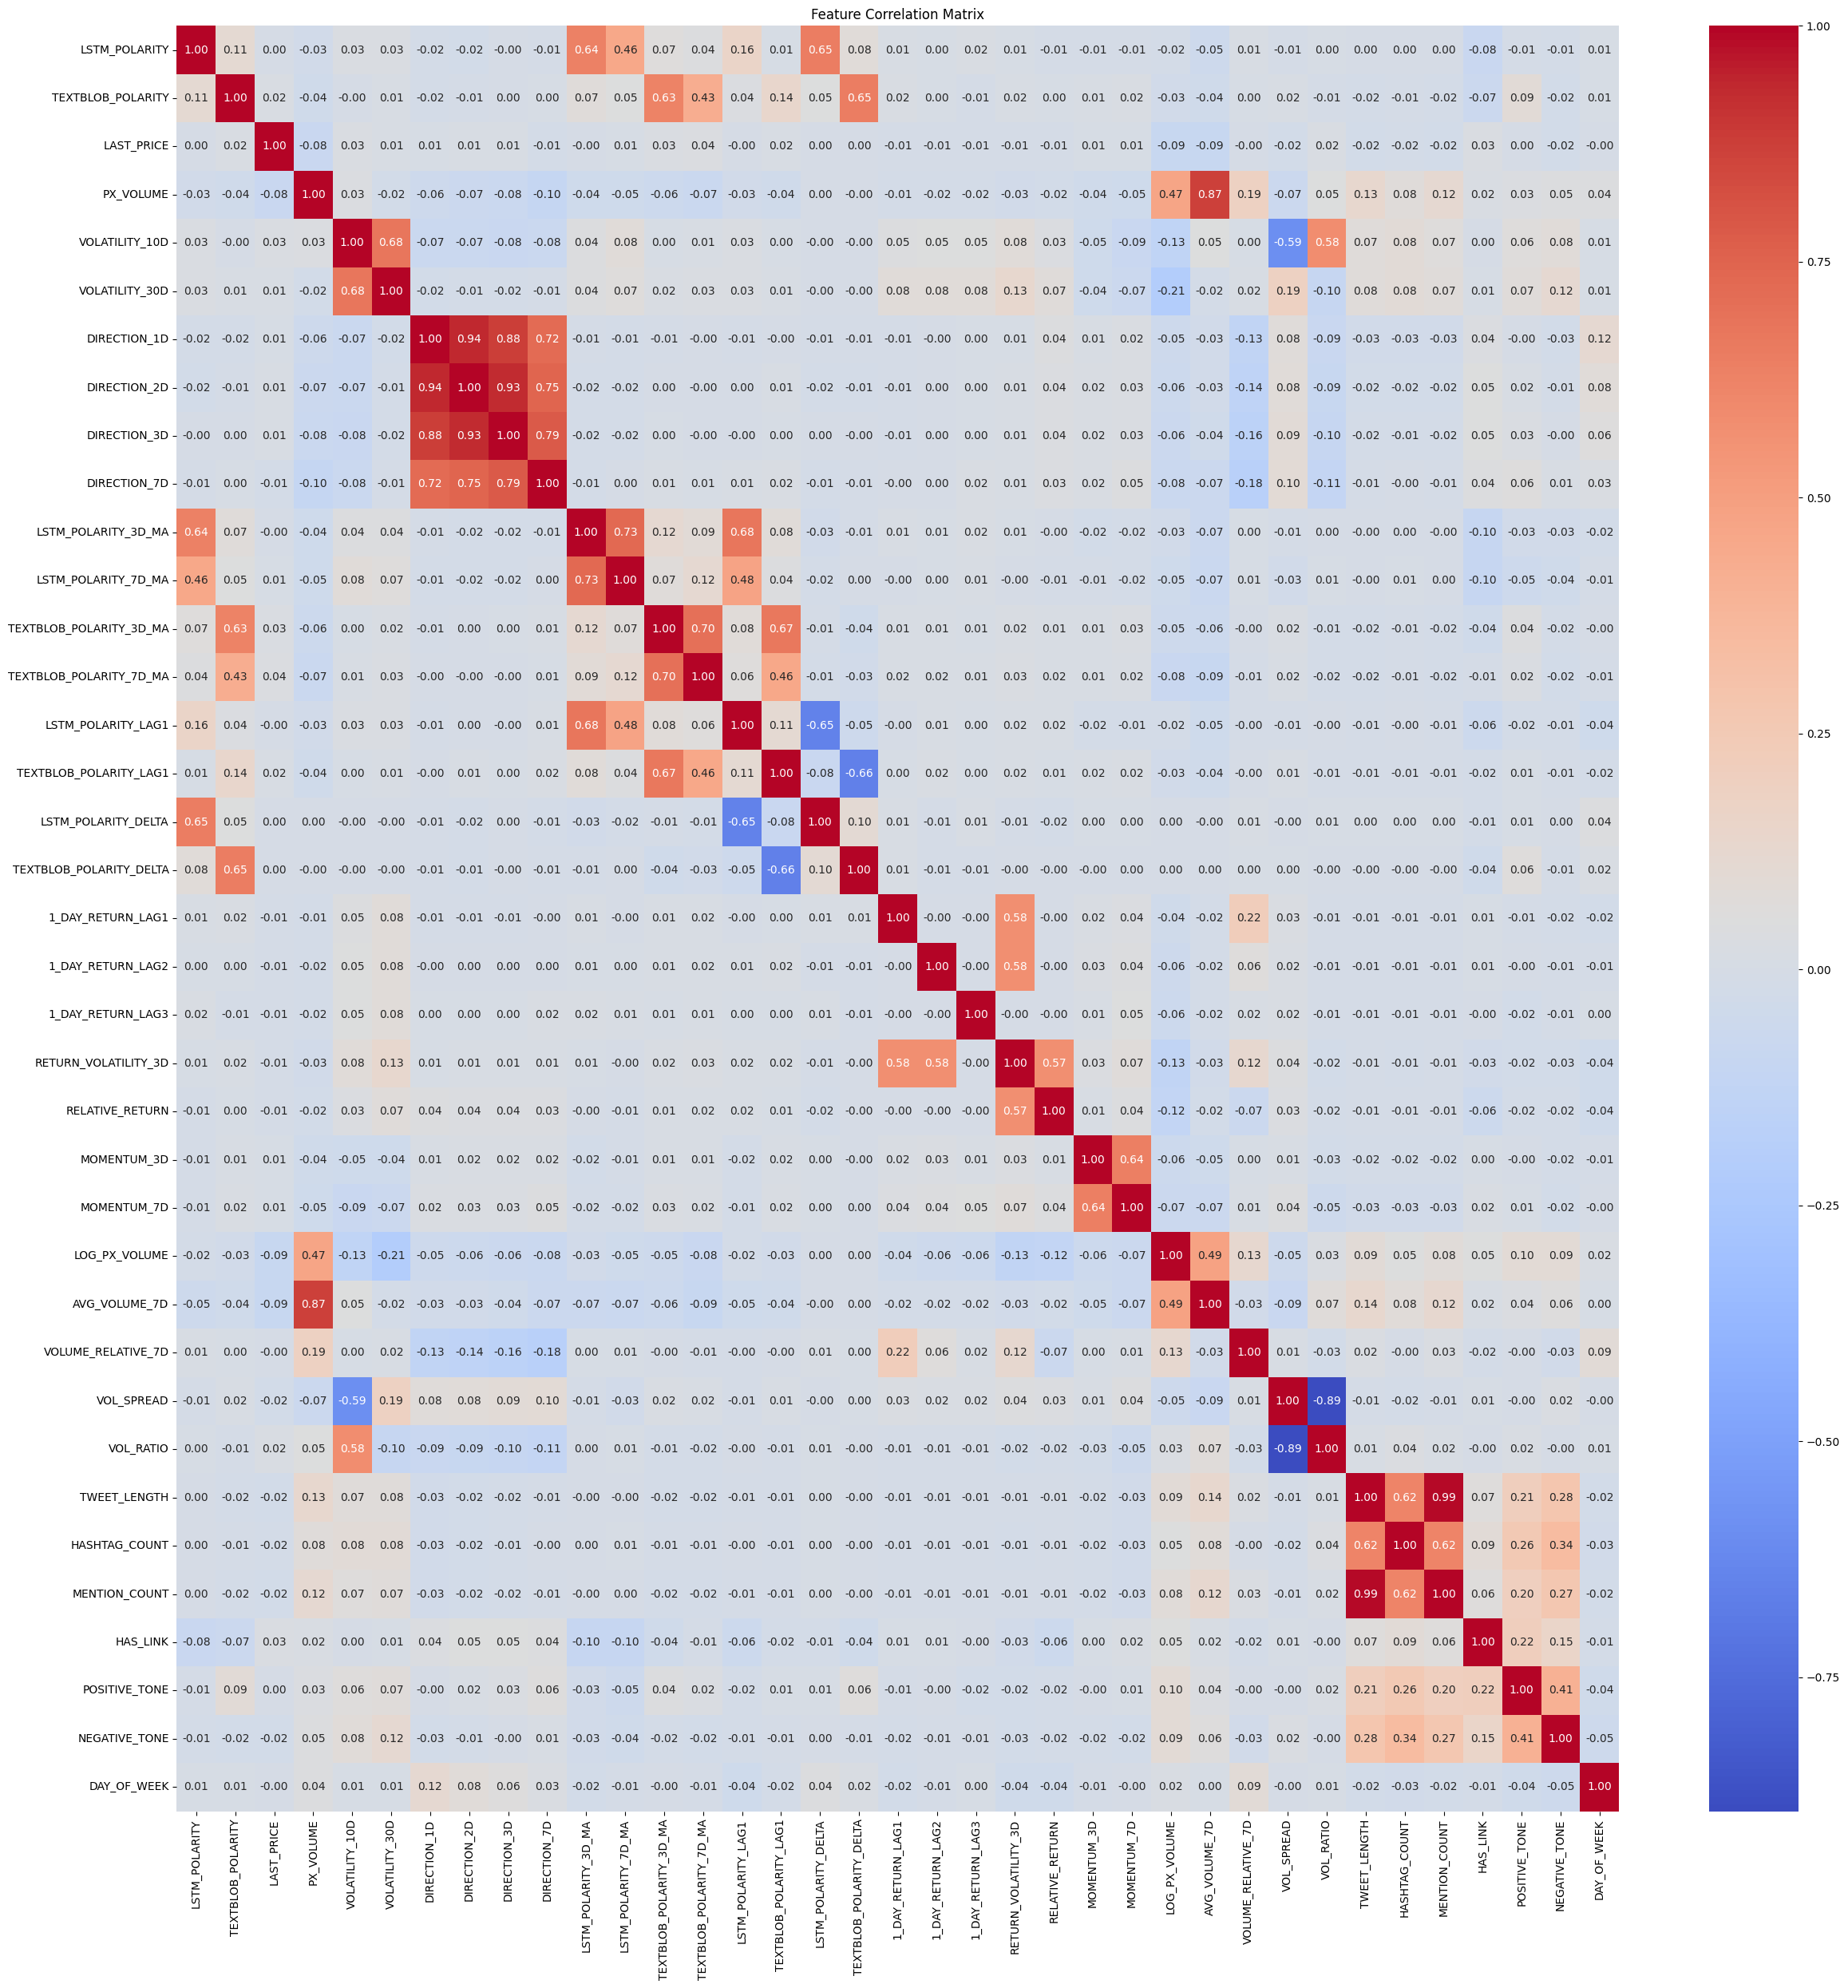

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix for numeric features (excluding targets)
target_cols = ['1_DAY_RETURN', '2_DAY_RETURN', '3_DAY_RETURN', '7_DAY_RETURN']
feature_cols = [col for col in df_eng_clean.select_dtypes(include=['number']).columns if col not in target_cols]
corr_matrix = df_eng_clean[feature_cols].corr()

plt.figure(figsize=(25,25))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()

# You can manually check this heatmap and consider dropping highly correlated redundant features (e.g. corr > 0.9)

# Random Forest feature importance

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from functools import reduce

X = df_eng_clean[feature_cols]
targets = ['1_DAY_RETURN', '2_DAY_RETURN', '3_DAY_RETURN', '7_DAY_RETURN']

importance_dfs = []

for target in targets:
    y = df_eng_clean[target]
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)

    importances = rf.feature_importances_
    df = pd.DataFrame({'feature': feature_cols, f'importance_{target}': importances})
    importance_dfs.append(df)

# Merge all importance dataframes on 'feature'
merged_df = reduce(lambda left, right: pd.merge(left, right, on='feature'), importance_dfs)

# Display importance scores per target first
print("Feature importances per target:")
print(merged_df)

# Calculate average importance
importance_cols = [f'importance_{t}' for t in targets]
merged_df['avg_importance'] = merged_df[importance_cols].mean(axis=1)

# Sort by average importance descending
sorted_avg = merged_df[['feature', 'avg_importance']].sort_values(by='avg_importance', ascending=False).reset_index(drop=True)

print("\nFeatures sorted by average importance:")
print(sorted_avg)


Feature importances per target:
                    feature  importance_1_DAY_RETURN  importance_2_DAY_RETURN  \
0             LSTM_POLARITY             2.405397e-05                 0.001668   
1         TEXTBLOB_POLARITY             8.518954e-04                 0.000752   
2                LAST_PRICE             1.082259e-03                 0.001383   
3                 PX_VOLUME             2.568030e-03                 0.001011   
4            VOLATILITY_10D             1.083683e-03                 0.001649   
5            VOLATILITY_30D             1.095416e-03                 0.004046   
6              DIRECTION_1D             5.123855e-15                 0.000002   
7              DIRECTION_2D             4.876382e-08                 0.000082   
8              DIRECTION_3D             5.787179e-08                 0.000006   
9              DIRECTION_7D             2.338226e-07                 0.000001   
10      LSTM_POLARITY_3D_MA             3.052347e-03                 0.000153

In [ ]:
# original_feature_cols = [...]  # List of original features before engineering
# sorted_avg already contains features and their avg_importance
original_feature_cols = [col for col in df_all_cleaned.select_dtypes(include=['number']).columns if col not in target_cols]
# Filter out original features
engineered_df = sorted_avg[~sorted_avg['feature'].isin(original_feature_cols)]

# Apply importance threshold
threshold = 0.0002
top_features = engineered_df[engineered_df['avg_importance'] >= threshold]['feature'].tolist()

print("\nTop engineered features based on average importance:")
print(top_features)



Top engineered features based on average importance:
['RELATIVE_RETURN', 'RETURN_VOLATILITY_3D', 'MOMENTUM_7D', 'TEXTBLOB_POLARITY_7D_MA', '1_DAY_RETURN_LAG3', 'LSTM_POLARITY_7D_MA', 'VOLUME_RELATIVE_7D', 'AVG_VOLUME_7D', 'TEXTBLOB_POLARITY_3D_MA', 'VOL_RATIO', 'MOMENTUM_3D', 'LSTM_POLARITY_DELTA', 'MENTION_COUNT', 'LSTM_POLARITY_LAG1', 'DAY_OF_WEEK', 'LOG_PX_VOLUME', 'VOL_SPREAD', 'HASHTAG_COUNT', 'TWEET_LENGTH', 'LSTM_POLARITY_3D_MA', 'TEXTBLOB_POLARITY_LAG1', '1_DAY_RETURN_LAG2', 'POSITIVE_TONE', '1_DAY_RETURN_LAG1']


In [ ]:
# Feature selection

threshold = 0.0002  # Adjust based on your preference
top_features = sorted_avg[sorted_avg['avg_importance'] >= threshold]['feature'].tolist()
top_features

['RELATIVE_RETURN',
 'RETURN_VOLATILITY_3D',
 'MOMENTUM_7D',
 'VOLATILITY_10D',
 'TEXTBLOB_POLARITY_7D_MA',
 'LSTM_POLARITY',
 'VOLATILITY_30D',
 '1_DAY_RETURN_LAG3',
 'LAST_PRICE',
 'LSTM_POLARITY_7D_MA',
 'VOLUME_RELATIVE_7D',
 'AVG_VOLUME_7D',
 'TEXTBLOB_POLARITY_3D_MA',
 'VOL_RATIO',
 'PX_VOLUME',
 'MOMENTUM_3D',
 'LSTM_POLARITY_DELTA',
 'MENTION_COUNT',
 'LSTM_POLARITY_LAG1',
 'DAY_OF_WEEK',
 'LOG_PX_VOLUME',
 'VOL_SPREAD',
 'HASHTAG_COUNT',
 'TWEET_LENGTH',
 'TEXTBLOB_POLARITY',
 'LSTM_POLARITY_3D_MA',
 'TEXTBLOB_POLARITY_LAG1',
 '1_DAY_RETURN_LAG2',
 'POSITIVE_TONE',
 '1_DAY_RETURN_LAG1']

In [ ]:
# Normalize/standardize

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_eng_clean[top_features])  # or selected features

# Save scaler to apply later to val/test sets!

In [ ]:
def build_sequences_with_features(df_grouped, original_df, feature_cols, sequence_length=7):
    sequences = []
    stock_list = df_grouped['STOCK'].unique()

    for stock in stock_list:
        stock_df = df_grouped[df_grouped['STOCK'] == stock].sort_values('DATE')
        feature_arrays = {col: stock_df[col].values for col in feature_cols}
        dates = stock_df['DATE'].values

        returns_df = original_df[original_df['STOCK'] == stock].groupby('DATE').agg({
            '1_DAY_RETURN': 'mean',
            '2_DAY_RETURN': 'mean',
            '3_DAY_RETURN': 'mean',
            '7_DAY_RETURN': 'mean'
        }).reindex(dates, fill_value=0)

        for i in range(len(stock_df) - sequence_length):
            seq = [[feature_arrays[col][j] for col in feature_cols] for j in range(i, i + sequence_length)]
            target = returns_df.iloc[i + sequence_length][['1_DAY_RETURN', '2_DAY_RETURN', '3_DAY_RETURN', '7_DAY_RETURN']].values
            sequences.append({
                'STOCK': stock,
                'SEQUENCE_DATE': dates[i + sequence_length],
                'SEQUENCE': seq,
                'TARGET_RETURN': target
            })

    return pd.DataFrame(sequences)

df_eng_seq = build_sequences_with_features(df_eng_clean, df_eng_clean, top_features)

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np

class StockSentimentDataset(Dataset):
    def __init__(self, df_final):
        self.sequences = [torch.tensor(seq, dtype=torch.float32) for seq in df_final['SEQUENCE']]
        self.targets = torch.tensor(np.stack(df_final['TARGET_RETURN'].values), dtype=torch.float32)  # shape: [N,4]

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return self.sequences[idx], self.targets[idx]

class SentimentLSTM(nn.Module):
    def __init__(self, input_size=17, hidden_size=64, num_layers=2, output_size=4):
        super(SentimentLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=0.3, bidirectional=True)
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(hidden_size * 2, output_size)  # output_size=4

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out[:, -1, :])
        return self.fc(out)  # returns shape: [batch_size, 4]

In [ ]:
from sklearn.model_selection import train_test_split

# 60% train, 20% val, 20% test
train_df, temp_df = train_test_split(df_eng_seq, test_size=0.4, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

batch_size = 32

# Create datasets/loaders
train_dataset = StockSentimentDataset(train_df)
val_dataset = StockSentimentDataset(val_df)
test_dataset = StockSentimentDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
# Classify return as:
# 1 if return > 0 (positive return)
# 0 if return <= 0 (negative or zero return)

from sklearn.metrics import mean_absolute_error, r2_score, f1_score, accuracy_score

def to_class(x):
    # x shape: [num_samples, 4]
    return (x > 0).astype(int)

def evaluate(model, dataloader, criterion, df_reference=None, indices=None):
    model.eval()
    total_loss = 0
    all_preds = []
    all_targets = []
    stock_ids = []

    with torch.no_grad():
        for i, (x_batch, y_batch) in enumerate(dataloader):
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            preds = model(x_batch)
            loss = criterion(preds, y_batch)

            total_loss += loss.item()
            all_preds.append(preds.cpu().numpy())
            all_targets.append(y_batch.cpu().numpy())

            if df_reference is not None and indices is not None:
                batch_indices = indices[i * dataloader.batch_size: i * dataloader.batch_size + len(x_batch)]
                batch_stocks = df_reference.iloc[batch_indices]['STOCK'].tolist()
                stock_ids.extend(batch_stocks)

    avg_loss = total_loss / len(dataloader)
    all_preds = np.vstack(all_preds)
    all_targets = np.vstack(all_targets)

    pred_classes = to_class(all_preds)
    target_classes = to_class(all_targets)

    maes, r2s, accs, f1s = [], [], [], []
    for i in range(4):
        mae = mean_absolute_error(all_targets[:, i], all_preds[:, i])
        r2 = r2_score(all_targets[:, i], all_preds[:, i])
        acc = accuracy_score(target_classes[:, i], pred_classes[:, i])
        f1 = f1_score(target_classes[:, i], pred_classes[:, i])
        maes.append(mae)
        r2s.append(r2)
        accs.append(acc)
        f1s.append(f1)

    return avg_loss, maes, r2s, accs, f1s, all_preds, all_targets, stock_ids

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = SentimentLSTM(len(top_features)).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 40

# Lists to accumulate val metrics per epoch
all_f1s = []
all_accs = []

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0

    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        preds = model(x_batch)  # shape [batch_size, 4]
        loss = criterion(preds, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    train_loss = total_train_loss / len(train_loader)
    val_loss, maes, r2s, accs, f1s, val_preds, val_targets, stock_ids = evaluate(model, val_loader, criterion)

    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    for i, horizon in enumerate(['1-Day', '2-Day', '3-Day', '7-Day']):
        print(f"  {horizon} -> MAE: {maes[i]:.4f}, R2: {r2s[i]:.4f}, Acc: {accs[i]:.4f}, F1: {f1s[i]:.4f}")

    all_f1s.append(f1s)
    all_accs.append(accs)

# Get final validation predictions with stock IDs
val_indices = val_df.index.to_list()
_, _, _, _, _, val_preds, val_targets, stock_ids = evaluate(
    model, val_loader, criterion, df_reference=df_eng_seq, indices=val_indices)

val_preds_bin = to_class(val_preds)
val_targets_bin = to_class(val_targets)

from collections import defaultdict

# Dictionary: stock -> list of (preds, targets)
stock_metrics = defaultdict(lambda: {i: {'pred': [], 'target': []} for i in range(4)})

for stock, pred_vec, target_vec in zip(stock_ids, val_preds_bin, val_targets_bin):
    for i in range(4):  # for each return horizon
        stock_metrics[stock][i]['pred'].append(pred_vec[i])
        stock_metrics[stock][i]['target'].append(target_vec[i])

# Now compute F1 for each stock per horizon
stock_f1_per_horizon = {i: {} for i in range(4)}  # i = 0 to 3 for 1D to 7D

for stock, metrics_by_horizon in stock_metrics.items():
    for i in range(4):
        preds = metrics_by_horizon[i]['pred']
        targets = metrics_by_horizon[i]['target']
        if len(set(targets)) > 1:  # ensure F1 is defined
            f1 = f1_score(targets, preds)
            stock_f1_per_horizon[i][stock] = f1

# Print top 5 stocks per horizon with both F1 and Accuracy
print("\nTop 5 Stocks by F1 Score per Return Horizon:")
for i, horizon in enumerate(['1-Day', '2-Day', '3-Day', '7-Day']):
    print(f"\n  {horizon}:")

    # Get stock-score pairs, sort by F1 descending
    sorted_stocks = sorted(stock_f1_per_horizon[i].items(), key=lambda x: x[1], reverse=True)

    # Print top 5 with accuracy
    for rank, (stock, f1_score_val) in enumerate(sorted_stocks[:5], start=1):
        preds = stock_metrics[stock][i]['pred']
        targets = stock_metrics[stock][i]['target']
        acc_score_val = accuracy_score(targets, preds) if len(preds) > 0 else 0.0

        print(f"    {rank}. {stock} (F1: {f1_score_val:.4f}, Acc: {acc_score_val:.4f})")

# Average F1 and Accuracy per horizon across all stocks
print("\nAverage F1 and Accuracy per Return Horizon (Across Stocks):")
for i, horizon in enumerate(['1-Day', '2-Day', '3-Day', '7-Day']):
    # Extract all per-stock F1s and Accuracies for this horizon
    f1_list = list(stock_f1_per_horizon[i].values())

    # Accuracy: calculate similarly
    acc_list = []
    for stock, metrics_by_horizon in stock_metrics.items():
        preds = metrics_by_horizon[i]['pred']
        targets = metrics_by_horizon[i]['target']
        if len(preds) > 0:
            acc = accuracy_score(targets, preds)
            acc_list.append(acc)

    avg_f1 = np.mean(f1_list) if f1_list else 0
    avg_acc = np.mean(acc_list) if acc_list else 0

    print(f"  {horizon} -> Avg F1: {avg_f1:.4f}, Avg Acc: {avg_acc:.4f}")


Epoch 1 | Train Loss: 731.0975 | Val Loss: 0.6024
  1-Day -> MAE: 0.0963, R2: -0.0073, Acc: 0.3466, F1: 0.5044
  2-Day -> MAE: 0.1430, R2: -0.0012, Acc: 0.3513, F1: 0.5166
  3-Day -> MAE: 0.1863, R2: 0.0021, Acc: 0.3513, F1: 0.5199
  7-Day -> MAE: 0.2911, R2: -0.0078, Acc: 0.3923, F1: 0.5620
Epoch 2 | Train Loss: 731.1109 | Val Loss: 0.5997
  1-Day -> MAE: 0.1161, R2: -0.0152, Acc: 0.3443, F1: 0.5044
  2-Day -> MAE: 0.1722, R2: -0.0086, Acc: 0.3466, F1: 0.5148
  3-Day -> MAE: 0.2107, R2: -0.0013, Acc: 0.3513, F1: 0.5199
  7-Day -> MAE: 0.3327, R2: 0.0002, Acc: 0.3899, F1: 0.5611
Epoch 3 | Train Loss: 730.9266 | Val Loss: 0.6023
  1-Day -> MAE: 0.1387, R2: -0.0421, Acc: 0.3419, F1: 0.5035
  2-Day -> MAE: 0.1870, R2: -0.0186, Acc: 0.3466, F1: 0.5148
  3-Day -> MAE: 0.2506, R2: -0.0204, Acc: 0.3513, F1: 0.5199
  7-Day -> MAE: 0.3866, R2: 0.0009, Acc: 0.3899, F1: 0.5611
Epoch 4 | Train Loss: 730.8539 | Val Loss: 0.6117
  1-Day -> MAE: 0.1516, R2: -0.0632, Acc: 0.3419, F1: 0.5044
  2-Day ->